# 1. Logistic regression in PyTorch (25 points)

You are supposed to fill in the missing lines in the notebook `Logistic Regression PyTorch Assignment.ipynb`. The tutorial https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html should provide you with all knowledge you need.

The notebook considers an example where 2D data points are classified using logistic regression and the solution is visualized. First, an implementation in Scikit-Learn is given. Then the same is partly implemented using PyTorch. Your assignment is to fill in the blanks in the PyTorch implementation.

You should add some code in several cells (indicated by "MISSING"). Please write these lines of code in your report, see the LATEX template.

Model      Training Accuracy    Test Accuracy  Weights                      Biases
-------  -------------------  ---------------  ---------------------------  -------------------------------------------------
Sklearn                 0.62             0.64  [[-1.20707034 -1.38041267]   [-0.136149    0.85479744 -0.56538437 -0.15326408]
                                                [ 0.4268915  -0.68760268]
                                                [-1.16837355  1.1938554 ]
                                                [ 1.94855239  0.87415996]]
PyTorch                 0.62             0.64  [[-1.0378658 -1.6496851]     [-0.03828776  0.9529721  -0.46718976 -0.05534959]
                                                [ 0.5958916 -0.956975 ]
                                                [-0.9994295  0.9245895]
                                                [ 2.1175113  0.6048198]]


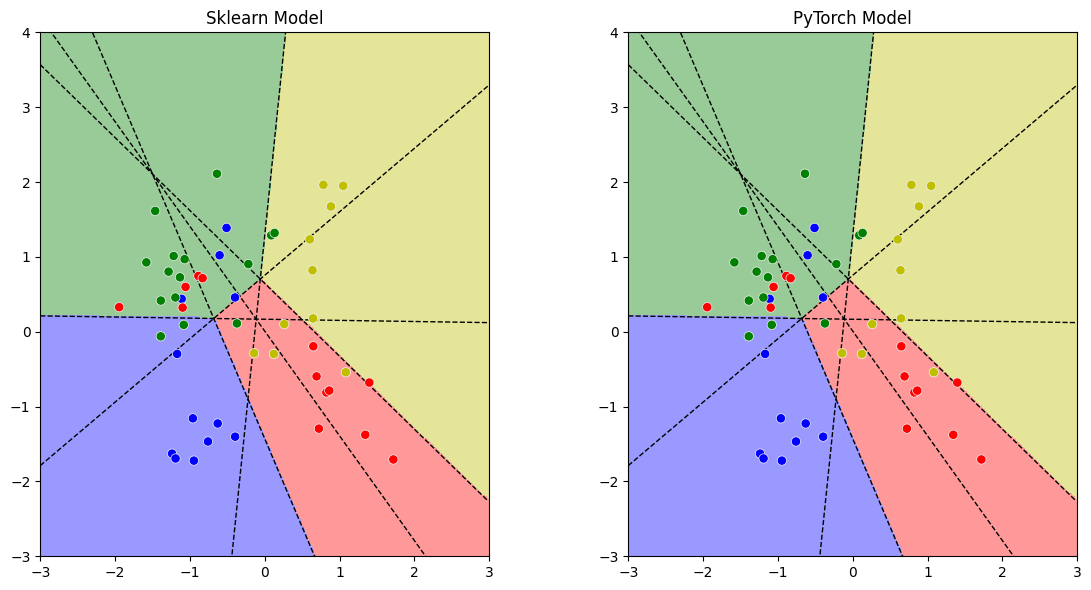

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate

m = 4  # Number of classes
d = 2  # In-out dimensionality
train_n = 50  # Training set size
test_n = 25  # Test set size
colors = ['b', 'r', 'g', 'y'] # Colors for the classes

# Data Generation
def generate_data():
    X, y = make_classification(n_samples=test_n + train_n,
                               n_features=d,
                               n_informative=d,
                               n_redundant=0,
                               n_repeated=0,
                               n_classes=m,
                               n_clusters_per_class=1,
                               weights=None,
                               flip_y=0.01,
                               class_sep=0.75,
                               hypercube=True,
                               shift=0.0,
                               scale=1.0,
                               shuffle=True,
                               random_state=None)
    return train_test_split(X, y, test_size=test_n, random_state=4711)

# Model Definitions
class LogisticRegressionPytorch(nn.Module):
    def __init__(self, d, m):
        super(LogisticRegressionPytorch, self).__init__()
        self.fc = nn.Linear(d, m) # HC: Linear layer with d inputs and m outputs

    def forward(self, x):
        return F.log_softmax(self.fc(x), dim=1) # HC: Softmax activation function

# Training Functions
def train_sklearn(X_train, y_train):
    logreg = LogisticRegression(penalty=None,
                                fit_intercept=True,
                                multi_class='multinomial',
                                solver='lbfgs')
    logreg.fit(X_train, y_train)
    return logreg

def train_pytorch(X_train, y_train):
    logreg_pytorch = LogisticRegressionPytorch(d, m)
    optimizer = optim.Adam(logreg_pytorch.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss() # HC: Cross entropy loss function
    X_train_T = torch.Tensor(X_train) # Automatically casts to foat
    y_train_T = torch.from_numpy(y_train).long() # Does not cast to float
    for _ in range(10000): # Loop over the dataset multiple times
        optimizer.zero_grad() # Zero the parameter gradients
        outputs = logreg_pytorch(X_train_T) # Forward + backward + optimize
        loss = criterion(outputs, y_train_T) # HC: Compute the loss
        loss.backward() # HC: Backpropagation
        optimizer.step()
    return logreg_pytorch

# Plotting
def plot_decision_boundary(X, y, model, ax, title, torch_model=False, add_colorbar=False):
    # Colors for the classes
    colors = ['b', 'r', 'g', 'y']
    class_colours = [colors[i] for i in y]
    cmap = plt.matplotlib.colors.ListedColormap(colors[:len(np.unique(y))])

    # Compute the plot boundaries
    xl, xh = np.floor(X[:, 0].min() - 1), np.ceil(X[:, 0].max() + 1)
    yl, yh = np.floor(X[:, 1].min() - 1), np.ceil(X[:, 1].max() + 1)

    # Create grid to calculate the decision boundary
    res = (xh - xl) / 300  # Resolution of the grid
    xx, yy = np.meshgrid(np.arange(xl, xh, res), np.arange(yl, yh, res))

    # Classify each point on the grid
    if torch_model:
        with torch.no_grad():  # Disable gradient tracking
            outputs = model(torch.Tensor(np.c_[xx.ravel(), yy.ravel()]))
        _, predicted = torch.max(outputs.data, 1)
        Z = predicted.numpy().reshape(xx.shape)
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

    # Plot points in their respective color classes
    ax.scatter(X[:, 0], X[:, 1], s=45, c=class_colours, edgecolor=plt.cm.gray(.95), lw=0.5, zorder=100)

    # Plot decision boundaries with dashed lines
    for i in np.arange(m - 1):
        for j in np.arange(i + 1, m):
            if torch_model:
                with torch.no_grad():  # Disable gradient tracking
                    w = model.fc.weight[i] - model.fc.weight[j]
                    b = model.fc.bias[i] - model.fc.bias[j]
                    b = -b / w[1]
                    a = -w[0] / w[1]
                    x_line = np.arange(xl, xh, res)
                    y_line = a * x_line + b
                    ax.plot(x_line, y_line, "k", lw=1, ls='--')
            else:
                w = model.coef_[i] - model.coef_[j]
                b = model.intercept_[i] - model.intercept_[j]
                b = -b / w[1]
                a = -w[0] / w[1]
                x_line = np.arange(xl, xh, res)
                y_line = a * x_line + b
                ax.plot(x_line, y_line, "k", lw=1, ls='--')

    ax.set_xlim(xl, xh)
    ax.set_ylim(yl, yh)

    ax.matshow(Z, cmap=cmap, origin="lower", extent=[xl, xh, yl, yh], aspect="auto", alpha=.4)

    ax.xaxis.tick_bottom()
    ax.set_aspect('equal')
    ax.set_title(title)

def pytorch_accuracy(model, X, y_true):
    with torch.no_grad():
        outputs = model(torch.Tensor(X))
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == torch.Tensor(y_true).long()).sum().item()
    return correct / len(y_true)

# Main Execution
X_train, X_test, y_train, y_test = generate_data()

# Train sklearn model
logreg = train_sklearn(X_train, y_train)
ws_sklearn = logreg.coef_
bs_sklearn = logreg.intercept_

# Train PyTorch model
logreg_pytorch = train_pytorch(X_train, y_train)
ws_torch = logreg_pytorch.fc.weight.detach().numpy() # HC: Get the weights of the linear layer
bs_torch = logreg_pytorch.fc.bias.detach().numpy() # HC: Get the biases of the linear layer

table = [
    ["Model", "Training Accuracy", "Test Accuracy", 'Weights', 'Biases'],
    ["Sklearn", logreg.score(X_train, y_train), logreg.score(X_test, y_test), ws_sklearn, bs_sklearn],
    ["PyTorch", pytorch_accuracy(logreg_pytorch, X_train, y_train), pytorch_accuracy(logreg_pytorch, X_test, y_test), ws_torch, bs_torch]
]
print(tabulate(table, headers='firstrow'))

# Plot decision boundaries side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_decision_boundary(X_train, y_train, logreg, ax1, 'Sklearn Model', add_colorbar=True)
plot_decision_boundary(X_train, y_train, logreg_pytorch, ax2, 'PyTorch Model', torch_model=True)
plt.tight_layout()
plt.show()

# 2. Convolutional Neural Networks

## 2.1. Sobel filter (25 points)

In this assignment, you should implement a Sobel filter in PyTorch. The learning goals are a better understanding of basic image filtering operations, a deep understanding of how the PyTorch convolutional layers work, and better PyTorch programming skills.

The Sobel filter is a basic operator to highlight edges in images (e.g., see Wikipedia). It convolves the image with two 3×3 filters, the results of which are combined. Let the matrix I represent a (single-channel) 2D input image and ∗ the convolution operator. Then the Sobel filter computes in a first step
$$
\mathbf{G}_x =
    \begin{bmatrix}
        1 & 0 & -1 \\
        2 & 0 & -2 \\
        1 & 0 & -1
    \end{bmatrix} \ast \mathbf{I}
    
    \quad \text{and} \quad
    
    \mathbf{G}_y =
    \begin{bmatrix}
        1 & 2 & 1 \\
        0 & 0 & 0 \\
        -1 & -2 & -1
    \end{bmatrix} \ast \mathbf{I},
\tag{1}
$$

which are then combined to a feature map
$$
[\mathbf{G}]_{ij} = \sqrt{[\mathbf{G}_x]_{ij}^2 + [\mathbf{G}_y]_{ij}^2}
\tag{2}
$$
where $[\cdot]_{ij}$ denotes the matrix element at position $ij$. Start by going through the notebook `PyTorch 2D convolutions.ipynb`, which gives some examples on how to work with 2D convolutions in PyTorch and provides some basics on how to read and display images. Do this carefully. First, it is surprising how many people doing deep learning in Python actually do not know what is going in a simple convolutional layer. Second, handling input images in real-world applications can sometimes be tricky (and I am not claiming that the way I did it in the notebook is the most elegant one).

Implement the Sobel filter. Use a single `nn.Conv2d` call to generate the two feature maps $\mathbf{G}_x$ and $\mathbf{G}_y$. For squaring each element in a filter output you can use something like `torch.square`. For combining filter outputs as in (2) you can use `torch.sum`, but you have to set the axis argument properly.

Deliverables: Show the important parts of your code (i.e., the Sobel filter) in the report. Apply the Sobel filter to the same input image as in `PyTorch 2D convolutions.ipynb`. Deliverables: Show plots of the two feature maps and the final result (i.e., $\mathbf{G}_x$, $\mathbf{G}_y$, and $\mathbf{G}$).

Deliverables: In the report, discuss how you considered the difference between convolution and cross-correlation (note that the latter is what the "convolutional" layer is doing) in your implementation.

### Sobel Filter Implementation

In [14]:
import torch
import torch.nn as nn

class SobelFilter(nn.Module):
    def __init__(self):
        super(SobelFilter, self).__init__()

        # Define the Sobel filter kernels
        self.sobel_kernel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).float().unsqueeze(0).unsqueeze(0)
        self.sobel_kernel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]).float().unsqueeze(0).unsqueeze(0)

        # Combine the kernels into a single tensor
        self.sobel_kernels = torch.cat([self.sobel_kernel_x, self.sobel_kernel_y], dim=0)

        # Create a convolutional layer with the Sobel filters
        self.conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, padding=1, bias=False)
        self.conv.weight.data = self.sobel_kernels

    def forward(self, x):
        # Check if the input tensor has a single channel
        if x.shape[1] != 1:
            raise ValueError("Input image should have a single channel (grayscale).")

        # Apply the Sobel filters
        Gx, Gy = torch.split(self.conv(x), 1, dim=1)

        # Compute the magnitude of the gradient
        G = torch.sqrt(torch.square(Gx) + torch.square(Gy))

        return Gx, Gy, G

Generate input image

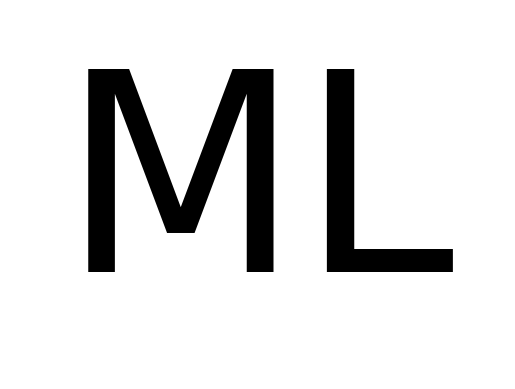

In [12]:
import matplotlib.pyplot as plt

text = "ML"
ax = plt.subplot()
ax.axis('off')
plt.text(0.5, 0.5, text, size=200, ha="center", va="center")
plt.savefig(f'images/{text}.jpg')

### Load the image and apply the Sobel filter

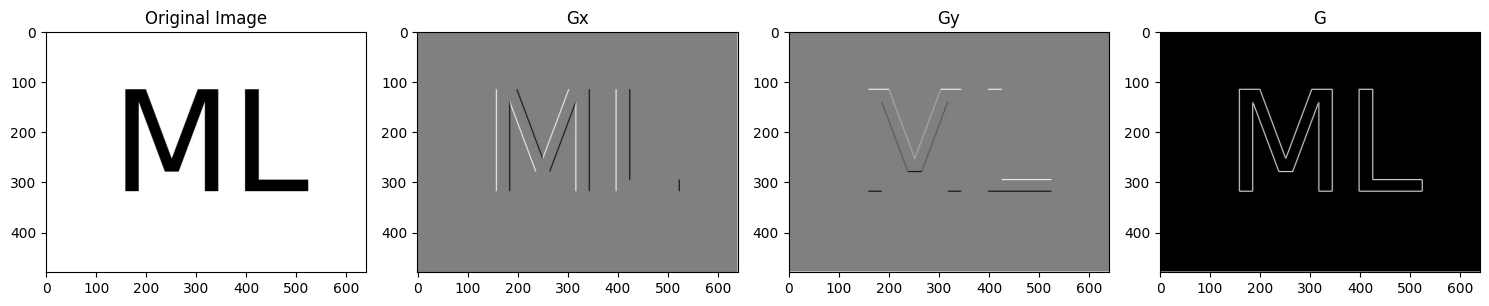

In [15]:
from PIL import Image
import torchvision.transforms as transforms

# Load the image
image = Image.open(image_path)

# Convert to grayscale
image = image.convert("L")

# Convert image to tensor and normalize
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension

# Create the Sobel filter model and pass the image through it
model = SobelFilter()
Gx, Gy, G = model(image_tensor)

# Display the results using matplotlib
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")

# Gx
plt.subplot(1, 4, 2)
plt.imshow(Gx[0, 0].detach().numpy(), cmap="gray")
plt.title("Gx")

# Gy
plt.subplot(1, 4, 3)
plt.imshow(Gy[0, 0].detach().numpy(), cmap="gray")
plt.title("Gy")

# G (Gradient Magnitude)
plt.subplot(1, 4, 4)
plt.imshow(G[0, 0].detach().numpy(), cmap="gray")
plt.title("G")

plt.tight_layout()
plt.show()

## 2.2. Convolutional neural networks (25 points)

The learning goal of this part of the assignment is to get more comfortable with implementing convolutional neural networks (CNNs) in PyTorch.

Consider the notebook `Torch_Traffic_Signs_Basic_Template.ipynb` and the file `GTSRBTrafficSigns.py`. The notebook is a template for training a convolutional neural network (CNN) for classifying traffic signs on the same data as the competition described by Stallkamp et al. (2012). The data is handled by the Dataset class in the file `GTSRBTrafficSigns.py`. Recognition of traffic signs is a challenging real-world problem of high industrial relevance. Traffic sign recognition can be viewed as a multi-class classification problem with unbalanced class frequencies, in which one has to cope with large variations in visual appearances due to illumination changes, partial occlusions, rotations, weather conditions, etc. However, humans are capable of recognizing the large variety of existing road signs with close to 100% correctness – not only in real-world driving situations, which provides both context and multiple views of a single traffic sign, but also when looking at single images as those shown in Figure 1. Now the question is how good a computer can become at solving this problem.

The notebook is supposed to run with GPU support, for example, using _Google Colaboratory_. Even then, executing it will take some time.

The notebook misses the CNN definition. Define a network with a
- convolutional layer creating 64 feature maps using 5×5 kernels followed by a
- 2 × 2 max-pooling layer followed by a
- convolutional layer creating 64 feature maps using 5×5 kernels followed by a
- 2 × 2 max-pooling layer followed by a
- linear fully-connected layer with 43 outputs.

After each convolutional layer, the ELU (exponential linear unit, Clevert et al. (2016)) activation function should be applied.

Deliverables: Show the model definition in the report.
You should get the following output when you print your model:
``````
    Net(
        ( conv1 ): Conv2d (3, 64, kernel_size =(5, 5) , stride =(1, 1))
        ( pool1 ): MaxPool2d ( kernel_size =2, stride =2, padding =0, dilation
        =1, ceil_mode = False )
        ( conv2 ): Conv2d (64 , 64, kernel_size =(5, 5) , stride =(1, 1))
        ( pool2 ): MaxPool2d ( kernel_size =2, stride =2, padding =0, dilation
        =1, ceil_mode = False )
        (fc2): Linear ( in_features =1024 , out_features =43, bias = True )
    )
``````

In [1]:
import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torchvision.datasets.utils import download_url, extract_archive

class GTSRBTrafficSigns(Dataset):
  """ GTSRB data set """

  def __init__(self, root = './', url = 'https://sid.erda.dk/share_redirect/EB0rrpZwuI', filename='EB0rrpZwuI.zip', train=True, crop_size=28, rotation=False):
    """
    Parameters:
    root: str
        Parent directory
    url: str
        URL of data set
    filename: str
        Filename of the zipped data
    train: bool
        Indicating whether training or test data should be considered
    crop_size: int
        Height and width of the input image
    """
    self.img_height  = 32
    self.img_width   = self.img_height
    self.img_height_crop = crop_size
    self.img_width_crop  = self.img_height_crop
    self.rotation = rotation # HC: added

    self.train = train

    # HC: changed
    folder_type = 'train' if self.train else 'test'
    rotation_folder = 'rotated' if self.rotation else 'not_rotated'
    archive = os.path.join(root, filename)
    self.data_folder = os.path.join(root, rotation_folder)
    dataset_folder = os.path.join(self.data_folder, 'GTSRB', folder_type)

    # Download the archive if not present
    if not os.path.exists(archive):
        download_url(url, root, filename)

    # Extract the archive if destination folder doesn't exist
    if not os.path.exists(dataset_folder):
        extract_archive(archive, self.data_folder, False)
    else:
        print(f'Using existing {self.data_folder}')

    self.dataset_train = datasets.ImageFolder(dataset_folder)

  def __getitem__(self, index):
      image, label = self.dataset_train.__getitem__(index)
      image = transforms.Resize((self.img_width,self.img_height))(image)

      if self.train:
        image = transforms.RandomAffine((-5,5))(image)
        image = transforms.RandomCrop((self.img_width_crop, self.img_height_crop))(image)
        image = transforms.ColorJitter(0.8, contrast = 0.4)(image)
        if self.rotation: # HC: added
          image = transforms.RandomRotation(15)(image)
        if label in [11, 12, 13, 17, 18, 26, 30, 35]:
          image = transforms.RandomHorizontalFlip(p=0.5)(image)
      else:
        image = transforms.CenterCrop((self.img_width_crop, self.img_height_crop))(image)

      image = transforms.ToTensor()(image)

      return image, label

  def __len__(self):
      return self.dataset_train.__len__()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tabulate import tabulate
from tqdm import tqdm

batch_size = 128

# Initialize device and check for GPU
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

def load_data(batch_size=128, rotation=False):
    dataset_train = GTSRBTrafficSigns(root="data", rotation=rotation)
    generator_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
    print("Number of training patterns:", len(dataset_train))
    return dataset_train, generator_train

def imshow(img, figsize=(2, 2)):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_sample_images(generator_train):
    dataiter = iter(generator_train)
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))
    for i in range(batch_size):
        imshow(images[i])
        print(labels[i].item(), "\n\n")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5) # HC: 3 RGB channels input, 64 feature maps, 5x5 kernel
        self.pool1 = nn.MaxPool2d(2, 2) # HC: 2x2 pooling
        self.conv2 = nn.Conv2d(64, 64, 5) # HC: 64 input feature maps, 64 output, 5x5 kernel
        self.pool2 = nn.MaxPool2d(2, 2) # HC: 2x2 pooling
        self.fc_input_size = 1024 # HC: Calculated from previous layers' output dimensions
        self.fc2 = nn.Linear(self.fc_input_size, 43) # HC: Fully connected layer for 43 classes

    def forward(self, x):
        x = self.pool1(F.elu(self.conv1(x))) # HC: Convolution -> ELU activation -> Pooling
        x = self.pool2(F.elu(self.conv2(x))) # HC: Convolution -> ELU activation -> Pooling
        x = x.view(-1, self.fc_input_size) # HC: Flatten for fully connected layer
        x = self.fc2(x) # HC: Final class scores
        return x

def train_model(net, generator_train, no_epochs=200):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001, eps=0.1)
    loss_history = []

    for _ in enumerate(tqdm(range(no_epochs), desc='Epochs', unit='epoch')):
        running_loss = 0.0
        total_samples = 0

        # Inner loop for batches within an epoch
        for i, data in enumerate(generator_train):
            inputs, labels = data[0].to(device) if gpu else data[0], data[1].to(device) if gpu else data[1]
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total_samples += 1

        # HC: Calculate and store average loss for the epoch
        loss_avg = running_loss / total_samples
        loss_history.append(loss_avg)

    return loss_history

def test_model(net, dataset_test, batch_size):
    generator_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)
    print("Number of test patterns:", len(dataset_test))

    criterion = nn.CrossEntropyLoss() # HC: Use the cross entropy to calculate the loss
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for data in generator_test:
            images, labels = data[0].to(device) if gpu else data[0], data[1].to(device) if gpu else data[1]
            outputs = net(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item() # HC: The testing loop is generally less computationally intensive than the training loop. You're not backpropagating errors or updating weights. Therefore, the overhead of computing and storing the loss for each batch is less of a concern.

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_loss = running_loss / len(generator_test) # HC: Calculate average loss over all batches
    accuracy = 100 * correct / total

    return accuracy, average_loss

device: cuda:0


In [7]:
dataset_train, generator_train = load_data(batch_size, rotation=False)
#show_sample_images(generator_train)

net = Net().to(device)
print(net)

# Continue training the model, starting from the weights of the previous model
cont = False
if cont:
    net.load_state_dict(torch.load('models/traffic_simple'))

100%|██████████| 290897892/290897892 [00:10<00:00, 26562751.41it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Number of training patterns: 39209
Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=1024, out_features=43, bias=True)
)


In [8]:
loss_train = train_model(net, generator_train)

Epochs: 100%|██████████| 200/200 [1:59:50<00:00, 35.95s/epoch]


In [10]:
# Save the model
torch.save(net.state_dict(), 'models/traffic_simple')

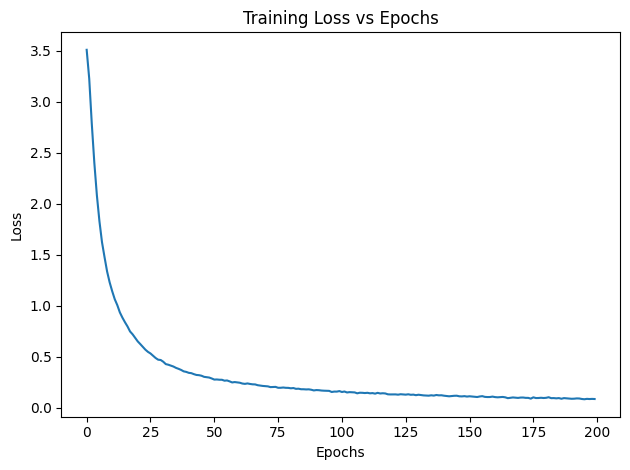

In [11]:
# HC: Plot the training loss vs epochs
plt.plot(loss_train)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.tight_layout()
plt.show()

In [12]:
dataset_test = GTSRBTrafficSigns(root="data", train=False, rotation=False)
accuracy_test, avg_loss_test = test_model(net, dataset_test, batch_size)

Using existing data/GTSRB/test
Number of test patterns: 12630


In [13]:
# HC: Print the test accuracy and average loss
print(tabulate([
        ['Accuracy', f'{accuracy_test:.2f} %'],
        ['Avg. Loss', f'{avg_loss_test:.4f}']
    ], headers=['Metric', 'Value']))

Metric     Value
---------  -------
Accuracy   94.20 %
Avg. Loss  0.4448


## 2.3. Augmentation (25 points)

Convolutional neural networks are highly complex models. To reduce the risk of overfitting and to be able to learn difficult tasks with a high input variability, many training examples are needed. Data augmentation is a way to enlarge the training data set by artificial training points generated from the available data. Data augmentation refers to applying transformations to the input data (the images) that do not change their labels. If we know, for example, that the classifications of images do not change when the images are rotated, then showing rotated versions of the images during the training process helps to learn this invariance property. In the context of neural networks, this type of data augmentation can be traced back to Baird (1992). It has been used successfully for CNNs, for instance, already in the influential work by Krizhevsky et al. (2012).

The learning goal of this part of the assignment is to get more experience in using data augmentation.

Inspect the notebook `Torch_Traffic_Signs_Basic_Template.ipynb`.

Deliverables: Answer the following questions briefly in your report: Which transformations are applied to the input images during training? Why is a transformation conditioned on the label?

Please add at least one additional (not completely nonsensical) transformation.

Deliverables: Show the corresponding code in your report and briefly argue why you think that this may be a reasonable augmentation given the task.

In [3]:
# Load data into a new dataset and generator so that the original data is not modified
dataset_train_rot, generator_train_rot = load_data(batch_size, rotation=True)
net_rot = Net().to(device)
print(net_rot)

# Continue training the model, starting from the weights of the previous model
cont = False
if cont:
    net_rot.load_state_dict(torch.load('models/traffic_simple_rotated'))

Using existing data/rotated
Number of training patterns: 39209


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=1024, out_features=43, bias=True)
)


In [4]:
loss_train_rot = train_model(net_rot, generator_train_rot)

Epochs: 100%|██████████| 200/200 [2:11:37<00:00, 39.49s/epoch]


In [5]:
# Save the model
torch.save(net_rot.state_dict(), 'models/traffic_simple_rotated')

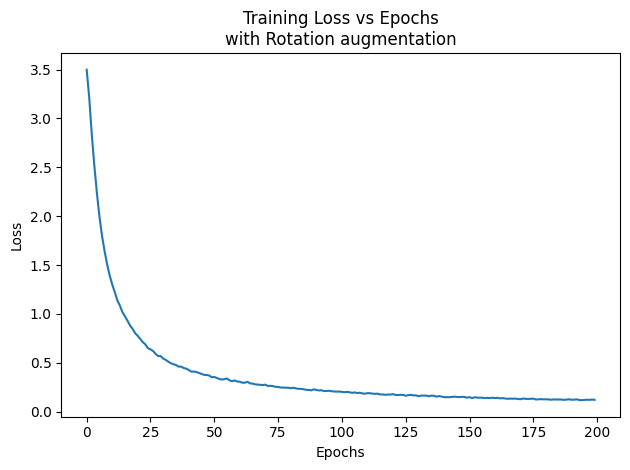

In [6]:
plt.plot(loss_train_rot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs\nwith Rotation augmentation')
plt.tight_layout()
plt.show()

In [7]:
dataset_test_rot = GTSRBTrafficSigns(root="data", train=False, rotation=True)
accuracy_test_rot, avg_loss_test_rot = test_model(net_rot, dataset_test_rot, batch_size)

Using existing data/rotated
Number of test patterns: 12630


In [9]:
print(tabulate([
        ['Accuracy', f'{accuracy_test_rot:.2f} %'],
        ['Avg. Loss', f'{avg_loss_test_rot:.4f}']
    ], headers=['Metric', 'Value']))

Metric     Value
---------  -------
Accuracy   94.73 %
Avg. Loss  0.3458
